In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from jupyter_utils import AllDataset

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(1)
from cxplain import CXPlain


data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'
enrichr_pathway = 'pathways/9606.enrichr_pathway.edge'
enrichr_pathway_nodemap = 'pathways/9606.enrichr_pathway.node_map'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)


drugs = [
    'bleomycin',
    'cisplatin',
    'cyclophosphamide',
    'docetaxel',
    'doxorubicin',]
#     'etoposide',
#     'gemcitabine'
#     'irinotecan',
#     'oxaliplatin',
#     'paclitaxel',
#     'pemetrexed',
#     'tamoxifen',
#     'temozolomide',
#     'vinorelbine']

# folder = 'CX_ens_enrichr3_diff'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from gene_finding.pathway_matrix import load_pathway, get_valid_enrichr_pathways

list_of_pathways = get_valid_enrichr_pathways(data_dir + enrichr_pathway_nodemap)
pathway_matrix, pathway_names = load_pathway(data_dir + enrichr_pathway, dataset.genes, list_of_pathways, 10, sort=True)

Number of Homo sapiens pathways: 490
Number of valid pathways: 439


In [3]:
mx = pd.DataFrame(pathway_matrix, index=pathway_names, columns=dataset.hgnc)

In [4]:
mx.sum(axis=1)

WIKIPATH_METASTATIC_BRAIN_TUMOR_HOMO_SAPIENS_WP2249                  6
WIKIPATH_TYPE_III_INTERFERON_SIGNALING_HOMO_SAPIENS_WP2113           7
NCI_SIGNALING_MEDIATED_BY_P38_GAMMA_AND_P38_DELTA_HOMO_SAPIENS_      8
WIKIPATH_IRINOTECAN_PATHWAY_HOMO_SAPIENS_WP229                       8
WIKIPATH_NUCLEOTIDE_GPCRS_HOMO_SAPIENS_WP80                          8
                                                                  ... 
WIKIPATH_EGF_EGFR_SIGNALING_PATHWAY_HOMO_SAPIENS_WP437             150
WIKIPATH_FOCAL_ADHESION_HOMO_SAPIENS_WP306                         171
WIKIPATH_INTEGRATED_PANCREATIC_CANCER_PATHWAY_HOMO_SAPIENS_WP23    175
WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594         183
WIKIPATH_GPCRS__CLASS_A_RHODOPSIN_LIKE_HOMO_SAPIENS_WP455          198
Length: 439, dtype: int64

In [5]:
mx.sum(axis=1)['WIKIPATH_CYTOPLASMIC_RIBOSOMAL_PROTEINS_HOMO_SAPIENS_WP477']

60

In [6]:
folder = 'CX_ens_enrichr3_deltascaled'
attr_dict = {}
conf_dict = {}
for i, drug in enumerate(drugs):
    print(drug)
    _, _, _, test_tcga_expr = dataset.filter_and_normalize_data(drug)
    exp = CXPlain.load('gene_finding/results/%s/%s/explainer'%(folder, drug), custom_model_loader=None, relpath=True)
    attr,conf = exp.explain_groups(test_tcga_expr.values)
    attr = pd.DataFrame(attr, index=test_tcga_expr.index, columns=pathway_names)
    attr_dict[drug]=attr
    conf_dict[drug] = conf

bleomycin
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
cisplatin
cyclophosphamide
docetaxel
doxorubicin


In [7]:
sv = attr_dict['cisplatin'].mean(axis=0).sort_values(ascending=False)

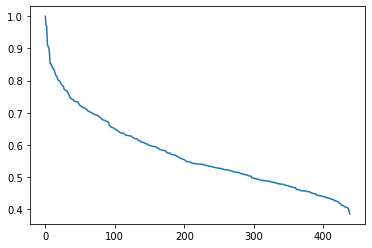

In [8]:
plt.plot(range(len(pathway_names)), sv/sv.max())

Text(0.5, 0, 'attribution')

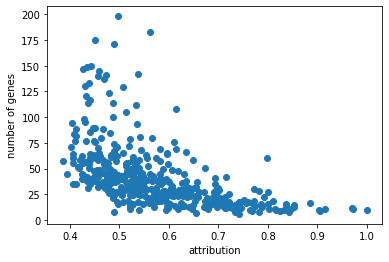

In [9]:
y = mx.sum(axis=1)[sv.index]
plt.scatter(sv/sv.max(), y)
plt.ylabel("number of genes")
plt.xlabel("attribution")

In [10]:
sv[:10]

NCI_ALPHA6_BETA4_INTEGRIN_LIGAND_INTERACTIONS_HOMO_SAPIENS_0141    0.003986
WIKIPATH_DOPAMINE_METABOLISM_HOMO_SAPIENS_WP2436                   0.003872
WIKIPATH_CHOLESTEROL_BIOSYNTHESIS_HOMO_SAPIENS_WP197               0.003863
NCI_SUMOYLATION_BY_RANBP2_REGULATES_TRANSCRIPTIONAL_REPRESSION_    0.003645
WIKIPATH_VITAMIN_D_METABOLISM_HOMO_SAPIENS_WP1531                  0.003608
WIKIPATH_SEROTONIN_TRANSPORTER_ACTIVITY_HOMO_SAPIENS_WP1455        0.003599
WIKIPATH_GLOBO_SPHINGOLIPID_METABOLISM_HOMO_SAPIENS_WP1424         0.003529
WIKIPATH_SULFATION_BIOTRANSFORMATION_REACTION_HOMO_SAPIENS_WP69    0.003396
NCI_CIRCADIAN_RHYTHM_PATHWAY_HOMO_SAPIENS_FFB11B85_6190_11E5_8A    0.003396
NCI_HYPOXIC_AND_OXYGEN_HOMEOSTASIS_REGULATION_OF_HIF_1_ALPHA_HO    0.003373
dtype: float32

In [11]:
from scipy.stats import pearsonr, spearmanr
print(spearmanr((sv/sv.max())[:20], y[:20]))
print(spearmanr((sv/sv.max())[:20], y[:20]))

SpearmanrResult(correlation=-0.19263034952157093, pvalue=0.4158384372515185)
SpearmanrResult(correlation=-0.19263034952157093, pvalue=0.4158384372515185)


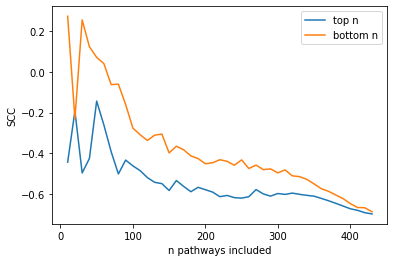

In [12]:
corr = []
corr_bot = []
for i in range(10, len(pathway_names), 10):
    corr.append(spearmanr((sv/sv.max())[:i], y[:i])[0])
    corr_bot.append(spearmanr((sv/sv.max())[-i:], y[-i:])[0])
    
plt.plot(range(10, len(pathway_names), 10), corr, label="top n")
plt.plot(range(10, len(pathway_names), 10), corr_bot, label="bottom n")
plt.xlabel("n pathways included")
plt.ylabel("SCC")
plt.legend()
plt.show()

bleomycin
WIKIPATH_LIVER_X_RECEPTOR_PATHWAY_HOMO_SAPIENS_WP2874              1.000000
NCI_SUMOYLATION_BY_RANBP2_REGULATES_TRANSCRIPTIONAL_REPRESSION_    0.926765
WIKIPATH_METASTATIC_BRAIN_TUMOR_HOMO_SAPIENS_WP2249                0.905267
WIKIPATH_NUCLEOTIDE_GPCRS_HOMO_SAPIENS_WP80                        0.890495
WIKIPATH_HOMOLOGOUS_RECOMBINATION_HOMO_SAPIENS_WP186               0.868478
dtype: float32
cisplatin
NCI_ALPHA6_BETA4_INTEGRIN_LIGAND_INTERACTIONS_HOMO_SAPIENS_0141    1.000000
WIKIPATH_DOPAMINE_METABOLISM_HOMO_SAPIENS_WP2436                   0.971441
WIKIPATH_CHOLESTEROL_BIOSYNTHESIS_HOMO_SAPIENS_WP197               0.969298
NCI_SUMOYLATION_BY_RANBP2_REGULATES_TRANSCRIPTIONAL_REPRESSION_    0.914422
WIKIPATH_VITAMIN_D_METABOLISM_HOMO_SAPIENS_WP1531                  0.905270
dtype: float32
cyclophosphamide
WIKIPATH_CHOLESTEROL_BIOSYNTHESIS_HOMO_SAPIENS_WP197               1.000000
WIKIPATH_TYPE_III_INTERFERON_SIGNALING_HOMO_SAPIENS_WP2113         0.788844
NCI_ALPHA6_BETA4_INTE

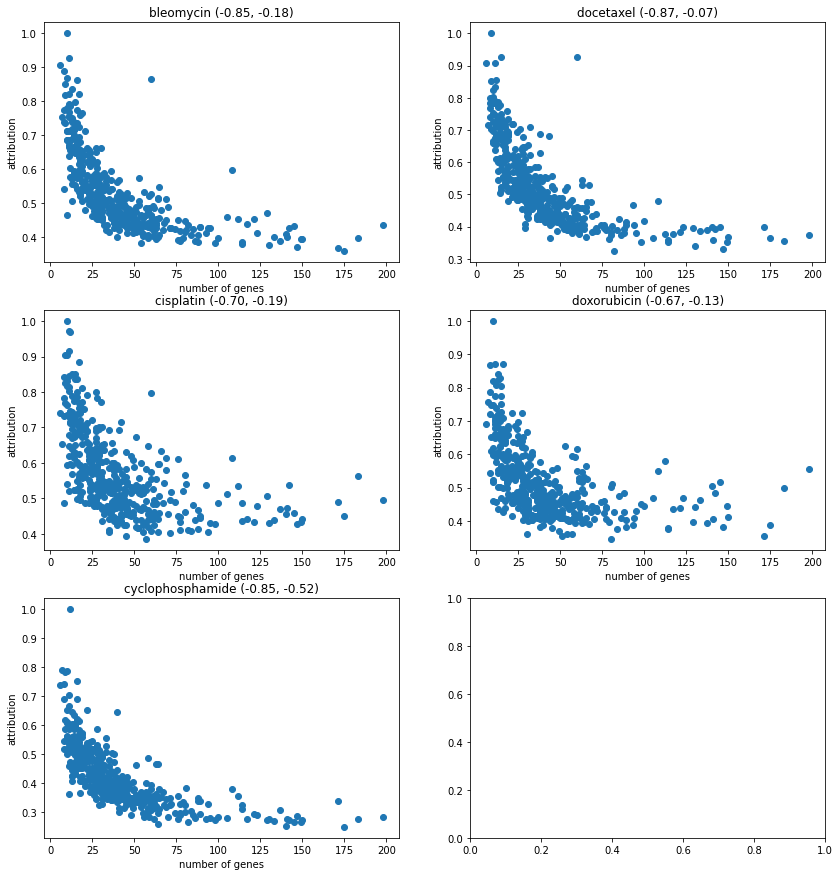

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

for i, drug in enumerate(drugs):
    sv = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    ax = axes[i%3][i//3]
    
    x = mx.sum(axis=1)[sv.index]
    ax.scatter(x, sv/sv.max())
    ax.set_xlabel("number of genes")
    ax.set_ylabel("attribution")
    
    scc_all = spearmanr((sv/sv.max()), x)[0]
    scc_top20 = spearmanr((sv/sv.max())[:20], x[:20])[0]
    
    print(drug)
    print((sv/sv.max())[:5])
    
    ax.set_title("%s (%0.2f, %0.2f)"%(drug, scc_all, scc_top20))
plt.show()

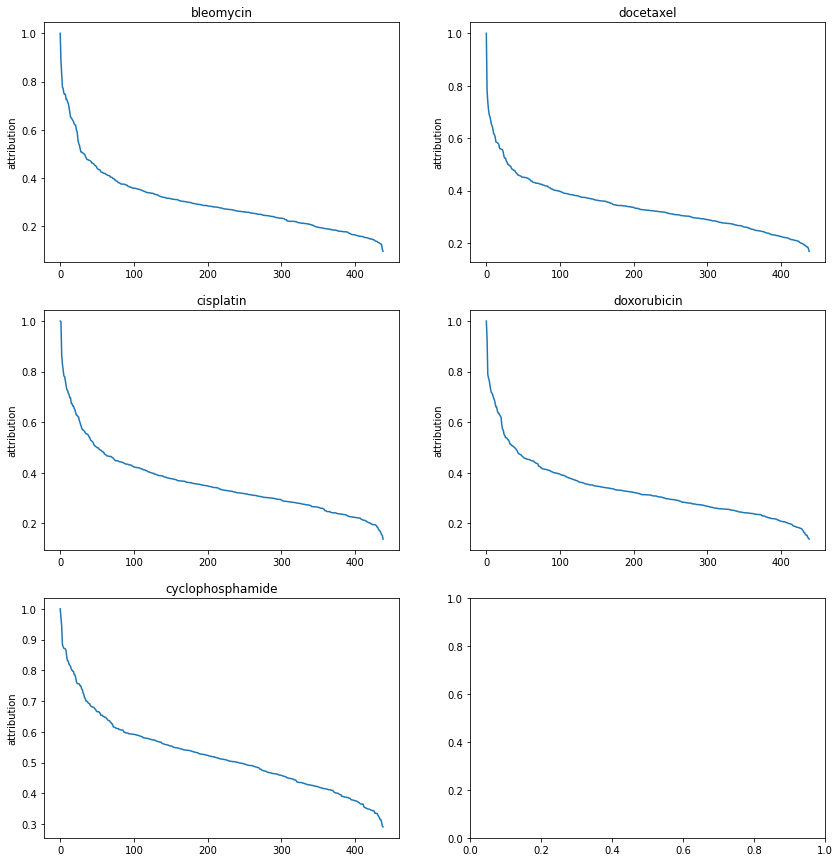

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

for i, drug in enumerate(drugs):
    sv = attr_dict[drug].mean(axis=0).sort_values(ascending=False)
    ax = axes[i%3][i//3]
    
    ax.plot(range(len(pathway_names)), sv/sv.max())
    
#     y = mx.sum(axis=1)[sv.index]
#     ax.scatter(sv/sv.max(), y)
#     ax.set_ylabel("number of genes")
    ax.set_ylabel("attribution")
    
#     scc_all = spearmanr((sv/sv.max()), y)[0]
#     scc_top20 = spearmanr((sv/sv.max())[:20], y[:20])[0]
    
#     print(drug)
#     print((sv/sv.max())[:20])
    
    ax.set_title("%s"%(drug))
plt.show()